# Model_V1

Breakdown of notebook:
1. **Imports**
<br><br>
2. **Helper-functions to...** 
    > - 2.1 ... Visualise RGB and Lab images
    > - 2.2 ... Train the model
    > - 2.3 ... Plot train and validation loss
3. **Create `ImageDataGenerators` for train and validation sets**
<br><br>
4. **Model architecture**
<br><br>
5. **Single image memorisation trial**
    > - 5.1.1 Get single image
    > - 5.1.2 Train model on single image
    > - 5.1.3 Test model on single image
6. **Train the model**
    > - 6.1 **Trainingrun_01**
        - 6.1.1 Get train images from folder
        - 6.1.2 Train the model
        - 6.1.3 Get test images from folder
        - 6.1.4 Test the model
        - 6.1.5 Save colourised images


---
## 1. Imports

In [1]:
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2lab, rgb2gray, lab2rgb
from skimage.io import imread, imshow, imsave
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

---

## 2. Helper-functions to...

### 2.1 ... Visualise RGB and Lab Images

These functions are the same as those in `Visualise_RGB_Lab.ipynb`.

In [2]:
# Helper-function for visualising images

def print_RGBimage(RGBimage, img_nchannels, img_height = 'H', img_width = 'W', savefig = False, figpath = None):
    
    fig, ax = plt.subplots(1, 4, figsize = (16, 4))
    
    # Plotting main image 
    if img_nchannels == 1:
        ax[0].imshow(RGBimage, cmap = plt.cm.gray)
    elif img_nchannels == 3:
        ax[0].imshow(RGBimage)
        
    ax[0].set_title("Original Image")
    ax[0].set_xlabel("W: " + str(img_width))
    ax[0].set_ylabel("H: " + str(img_height))
    ax[0].set_frame_on(False)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    # Plotting RGB channels
    if img_nchannels == 3:
        for i, cmap in enumerate(["Reds", "Greens", "Blues"]):
            ax[i+1].imshow(RGBimage[:, :, i], cmap = cmap)
            ax[i+1].set_title(cmap[0])
            ax[i+1].set_frame_on(False)
            ax[i+1].set_xticks([])
            ax[i+1].set_yticks([])
    
    plt.tight_layout()
    
    # Optional savefig
    if savefig:
        fig.savefig(fname = figpath)

        
def print_Labimage(Labimage, img_height = 'H', img_width = 'W', savefig = False, figpath = None):
    
    labimg_rescaled = (Labimage + [0, 128, 128]) / [100, 255, 255]
    
    fig, ax = plt.subplots(1, 4, figsize = (16, 4))
    
    ax[0].imshow(labimg_rescaled)
    ax[0].set_title("Lab Image")
    ax[0].set_xlabel("W: " + str(img_width))
    ax[0].set_ylabel("H: " + str(img_height))
    ax[0].set_frame_on(False)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    for i, col in enumerate(['L', 'a', 'b']):
        
        if col == 'L':
            ax[i+1].imshow(labimg_rescaled[:, :, i], cmap = plt.cm.gray)
        elif col == 'a':
            ax[i+1].imshow(labimg_rescaled[:, :, i], cmap = 'RdYlGn_r')
        elif col == 'b':
            ax[i+1].imshow(labimg_rescaled[:, :, i], cmap = 'YlGnBu_r')
            
        ax[i+1].set_title(col)
        ax[i+1].set_frame_on(False)
        ax[i+1].set_xticks([])
        ax[i+1].set_yticks([])

    plt.tight_layout()
    
    # Optional savefig
    if savefig:
        fig.savefig(fname = figpath)
    
    
def RGBimage_summary(RGBimage, savefig = False, figpath = None):

    '''Prints a summary of key information of a RGB image and
    prints the image together with is RGB breakdown. RGBimage has
    to be a Numpy array with integers ranging [0, 255].'''
    
    print("=================")
    print("RGB Image Summary")
    print("=================")
    
    RGBimg = RGBimage.astype(int)
    
    img_type = type(RGBimg)
    print(f"Object type: {img_type}")
    
    img_dim = RGBimg.shape
    img_height, img_width = img_dim[0], img_dim[1]
    print(f"Image dimensions: {img_dim}")

    img_nchannels = 1 if len(img_dim) == 2 else img_dim[-1]
    print(f"Number of channels: {img_nchannels}")
    
    if img_nchannels == 3:
        R_max, R_min = np.max(RGBimg[:, :, 0]), np.min(RGBimg[:, :, 0])
        G_max, G_min = np.max(RGBimg[:, :, 1]), np.min(RGBimg[:, :, 1])
        B_max, B_min = np.max(RGBimg[:, :, 2]), np.min(RGBimg[:, :, 2])
        
        print (f"R range: [{R_min}, {R_max}]")
        print (f"G range: [{G_min}, {G_max}]")
        print (f"B range: [{B_min}, {B_max}]")
        
    elif img_nchannels == 1:
        Gray_max, Gray_min = np.max(RGBimg), np.min(RGBimg)
        print(f"Gray range: [{Gray_min}, {Gray_max}]")

    
    # ===== Print image =====
    print_RGBimage(RGBimage = RGBimg,
                   img_nchannels = img_nchannels,
                   img_width = img_width,
                   img_height = img_height,
                   savefig = savefig,
                   figpath = figpath)
    

    
def Labimage_summary(Labimage, savefig = False, figpath = None):

    '''Prints a summary of key information of a Lab image and
    prints the image together with is RGB breakdown.'''
    
    print("=================")
    print("Lab Image Summary")
    print("=================")
    
    Labimg = Labimage
    
    img_type = type(Labimg)
    print(f"Object type: {img_type}")
    
    img_dim = Labimg.shape
    img_height, img_width, img_nchannels = img_dim[0], img_dim[1], img_dim[2]
    print(f"Image dimensions: {img_dim}")
    print(f"Number of channels: {img_nchannels}")
    
    L_max, L_min = np.max(Labimg[:, :, 0]), np.min(Labimg[:, :, 0])
    a_max, a_min = np.max(Labimg[:, :, 1]), np.min(Labimg[:, :, 1])
    b_max, b_min = np.max(Labimg[:, :, 2]), np.min(Labimg[:, :, 2])

    print (f"L range: [{L_min}, {L_max}]")
    print (f"a range: [{a_min}, {a_max}]")
    print (f"b range: [{b_min}, {b_max}]")
    
    
    # ===== Print image =====
    print_Labimage(Labimage = Labimg,
                   img_width = img_width,
                   img_height = img_height,
                   savefig = savefig,
                   figpath = figpath)

### 2.2 ... Train the model

In [14]:
def train_and_save_model(trainingrun, Xtrain, model, validation_split, batch_size, epochs, steps_per_epoch, validation_steps, checkpoint_filepath):
    
    '''Function to train the model and save using ModelCheckpoint and EarlyStopping.'''
    
    print("=============================")
    print(f" ##### TRAINING RUN {trainingrun} #####")
    print("=============================")
    print()
    print()
    
    # Print model summary
    print("===============")
    print(" MODEL SUMMARY ")
    print("===============")
    print(model.summary())
    print()
    print()
    
    # Print information about training and validation set
    print("===========================")
    print(" TRAIN/VAL DATASET SUMMARY ")
    print("===========================")
    total_train_size = len(Xtrain)
    train_size = round((1 - validation_split) * total_train_size)
    validation_size = round(validation_split * total_train_size)
    print(f"Size of total training set    : {len(Xtrain)}")
    print(f"(Training, validation) split  : ({1 - validation_split}, {validation_split})")
    print(f"Size of training set          : {1 - validation_split} * {total_train_size} = {train_size}")
    print(f"Size of validation set        : {validation_split} * {total_train_size} = {validation_size}")
    print()
    print()
    
    # Checkpoint
    checkpoint = ModelCheckpoint(filepath = checkpoint_filepath,
                                 monitor = "loss",
                                 mode = "min",
                                 save_best_only = False,
                                 save_weights_only = False,
                                 save_freq = "epoch",
                                 verbose = 2)
    
    # Early Stop
    earlystop = EarlyStopping(monitor = "loss",
                              mode = "min",
                              patience = 100,
                              restore_best_weights = True,
                              verbose = 1)
    
    callbacks_list = [checkpoint, earlystop]
    
    # Train model
    print("=====================================")
    print(" TRAIN, VALIDATE AND SAVE CHECKPOINT ")
    print("=====================================")
    model_info = model.fit(x = TrainImage_a_b_gen(Xtrain, batch_size, validation_split),
                           epochs = epochs,
                           steps_per_epoch = steps_per_epoch,
                           validation_data = ValidationImage_a_b_gen(Xtrain, batch_size, validation_split),
                           validation_steps = validation_steps,
                           callbacks = callbacks_list,
                           verbose = 1)
    
    print()
    print()
    print(f"##### END OF TRAINING RUN {trainingrun} #####")
    
    return model_info



### 2.3 ... Plot train and validation loss

In [4]:
def plot_TrainValLoss(model_info, trainingrun, savefig = False, figpath = None):
    
    print(model_info.history.keys())
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors_list = ["#000000", "#FF9900"]
    
    i = 0
    for key in model_info.history.keys():
        ax.plot(model_info.history[key], color = colors_list[i], linestyle = "-", label = key)
        i += 1
        
    # Set title
    title = "Trainingrun_" + trainingrun
    ax.set_title(title)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    
    # Hide the right and top spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")
    
    # Axis stuffs
    ax.set_ylim(bottom = 0)
    ax.set_xlim(xmin = 0)
    
    # Set legend
    ax.legend(loc = "upper left")
    
    plt.tight_layout()
    
    # Optional savefig
    if savefig:
        fig.savefig(fname = figpath)

---
## 3. Create `ImageDataGenerators` for train and validation sets

In [16]:
# Create image generator for image augmentation during training
def TrainImage_a_b_gen(Xtrain, batch_size, validation_split):
    '''Function that gets the training images using the flow method
    via train_generator and applies the data augmentation of train_datagen.
    This function is then used in the .fit() method when training the model.
    
    Note that this returns a tuple of (inputs, targets),
    where inputs is a np.array with shape (batch_size, h, w, 1)
    and targets is a np.array with shape (batch_sze, h, w, 2).'''
    
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                       shear_range = 0.2,
                                       zoom_range = 0.2,
                                       rotation_range = 15,
                                       horizontal_flip = True,
                                       validation_split = validation_split)
    
    train_generator = train_datagen.flow(x = Xtrain,
                                         batch_size = batch_size,
                                         subset = "training",
                                         save_to_dir = "Model_V1_Trainingrun_singleimage/InputImages/AugmentedTrainImages", 
                                         save_prefix = "AugmentedTrain",
                                         save_format = "png",
                                         shuffle = True,
                                         seed = 42)
    
    # Generate the tuple (X, Y) for each training batch
    for batch in train_generator:
        lab_batch = rgb2lab(batch)
        Xtrain_batch = lab_batch[:, :, :, 0]
        Ytrain_batch = lab_batch[:, :, :, 1:] / 128 # Normalise the values to [-1.0, 1.0]
        yield (Xtrain_batch.reshape(Xtrain_batch.shape + (1, )), Ytrain_batch)
        

def ValidationImage_a_b_gen(Xtrain, batch_size, validation_split):
    
    validation_datagen = ImageDataGenerator(rescale = 1./255,
                                            validation_split = validation_split)
    
    validation_generator = validation_datagen.flow(x = Xtrain,
                                                   batch_size = batch_size,
                                                   subset = "validation",
                                                   save_to_dir = "Model_V1_Trainingrun_singleimage/InputImages/AugmentedValImages", 
                                                   save_prefix = "AugmentedVal",
                                                   save_format = "png",
                                                   shuffle = True,
                                                   seed = 42)
    
    # Generate the tuple (X, Y) for each validation batch
    for batch in validation_generator:
        lab_batch = rgb2lab(batch)
        Xval_batch = lab_batch[:, :, :, 0]
        Yval_batch = lab_batch[:, :, :, 1:] / 128
        yield (Xval_batch.reshape(Xval_batch.shape + (1, )), Yval_batch)
        

---
## 4. Model_V1 architecture

In [17]:
model_V1 = Sequential(name = "Model_V1-Colouring-Pokemon")

model_V1.add(InputLayer(input_shape = (288, 320, 1)))
model_V1.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = "same"))
model_V1.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = "same", strides = 2))
model_V1.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = "same"))
model_V1.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = "same", strides = 2))
model_V1.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = "relu", padding = "same"))
model_V1.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = "relu", padding = "same", strides = 2))
model_V1.add(Conv2D(filters = 256, kernel_size = (3, 3), activation = "relu", padding = "same"))
model_V1.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = "relu", padding = "same"))
model_V1.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = "same"))
model_V1.add(UpSampling2D((2, 2)))
model_V1.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = "same"))
model_V1.add(UpSampling2D((2, 2)))
model_V1.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = "relu", padding = "same"))
model_V1.add(Conv2D(filters = 2, kernel_size = (3, 3), activation = "tanh", padding = "same"))
model_V1.add(UpSampling2D((2, 2)))

In [18]:
model_V1.compile(optimizer = "rmsprop", loss = "mse")
model_V1.summary()

Model: "Model_V1-Colouring-Pokemon"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 288, 320, 32)      320       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 144, 160, 32)      9248      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 144, 160, 64)      18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 72, 80, 64)        36928     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 72, 80, 128)       73856     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 36, 40, 128)       147584    
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 36, 

---

## 5.1 Single Image memorisation trial

**trainingrun_singleimage**
 - Size of training set = 1
 - Epochs = 1000, EarlyStop at 283
 - Batch size = 1
 - Steps per epoch = 1
 - Validation steps = 1

### 5.1.1 Get single image

In [12]:
# Get SingeImage
singleimage_rgb = img_to_array(load_img('Model_V1_Trainingrun_singleimage/InputImages/PokemonSilver_141.jpg'))
singleimage_lab = rgb2lab((1.0 / 255) * singleimage_rgb)

singleimage_rgb_traininput = singleimage_rgb.reshape(1, 288, 320, 3)

singleimage_lab_predict = singleimage_lab.reshape(1, 288, 320, 3)
singleimage_lab_predict_X = singleimage_lab_predict[:, :, :, 0].reshape(1, 288, 320, 1)
singleimage_lab_predict_Y = singleimage_lab_predict[:, :, :, 1:]

### 5.1.2 Train model on single image

In [19]:
singleimage_info = train_and_save_model(trainingrun = "singleimage", 
                                        Xtrain = singleimage_rgb_traininput,
                                        model = model_V1,
                                        validation_split = 0,
                                        batch_size = 1,
                                        epochs = 1000,
                                        steps_per_epoch = 1,
                                        validation_steps = 1,
                                        checkpoint_filepath = "Model_V1_trainingrun_singleimage/SavedCheckpoints/model.{epoch:02d}-{val_loss:.6f}.hdf5")

 ##### TRAINING RUN singleimage #####


 MODEL SUMMARY 
Model: "Model_V1-Colouring-Pokemon"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 288, 320, 32)      320       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 144, 160, 32)      9248      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 144, 160, 64)      18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 72, 80, 64)        36928     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 72, 80, 128)       73856     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 36, 40, 128)       147584    
__________________________________________________

Epoch 21/1000
1/1 [==============================] - ETA: 0s - loss: 0.7569
Epoch 00021: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.21-0.000000.hdf5
1/1 [==============================] - 0s 92ms/step - loss: 0.7569 - val_loss: 0.0000e+00
Epoch 22/1000
1/1 [==============================] - ETA: 0s - loss: 0.6608
Epoch 00022: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.22-0.000000.hdf5
1/1 [==============================] - 0s 95ms/step - loss: 0.6608 - val_loss: 0.0000e+00
Epoch 23/1000
1/1 [==============================] - ETA: 0s - loss: 0.7367
Epoch 00023: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.23-0.000000.hdf5
1/1 [==============================] - 0s 83ms/step - loss: 0.7367 - val_loss: 0.0000e+00
Epoch 24/1000
1/1 [==============================] - ETA: 0s - loss: 0.7346
Epoch 00024: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.24-0.000000.hdf5
1/1 [=============

Epoch 52/1000
1/1 [==============================] - ETA: 0s - loss: 0.8891
Epoch 00052: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.52-0.000000.hdf5
1/1 [==============================] - 0s 100ms/step - loss: 0.8891 - val_loss: 0.0000e+00
Epoch 53/1000
1/1 [==============================] - ETA: 0s - loss: 0.5355
Epoch 00053: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.53-0.000000.hdf5
1/1 [==============================] - 0s 89ms/step - loss: 0.5355 - val_loss: 0.0000e+00
Epoch 54/1000
1/1 [==============================] - ETA: 0s - loss: 0.1109
Epoch 00054: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.54-0.000000.hdf5
1/1 [==============================] - 0s 99ms/step - loss: 0.1109 - val_loss: 0.0000e+00
Epoch 55/1000
1/1 [==============================] - ETA: 0s - loss: 0.1675
Epoch 00055: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.55-0.000000.hdf5
1/1 [============

Epoch 83/1000
1/1 [==============================] - ETA: 0s - loss: 0.0965
Epoch 00083: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.83-0.000000.hdf5
1/1 [==============================] - 0s 96ms/step - loss: 0.0965 - val_loss: 0.0000e+00
Epoch 84/1000
1/1 [==============================] - ETA: 0s - loss: 0.0948
Epoch 00084: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.84-0.000000.hdf5
1/1 [==============================] - 0s 90ms/step - loss: 0.0948 - val_loss: 0.0000e+00
Epoch 85/1000
1/1 [==============================] - ETA: 0s - loss: 0.0894
Epoch 00085: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.85-0.000000.hdf5
1/1 [==============================] - 0s 98ms/step - loss: 0.0894 - val_loss: 0.0000e+00
Epoch 86/1000
1/1 [==============================] - ETA: 0s - loss: 0.0898
Epoch 00086: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.86-0.000000.hdf5
1/1 [=============

Epoch 114/1000
1/1 [==============================] - ETA: 0s - loss: 0.0901
Epoch 00114: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.114-0.000000.hdf5
1/1 [==============================] - 0s 87ms/step - loss: 0.0901 - val_loss: 0.0000e+00
Epoch 115/1000
1/1 [==============================] - ETA: 0s - loss: 0.0960
Epoch 00115: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.115-0.000000.hdf5
1/1 [==============================] - 0s 95ms/step - loss: 0.0960 - val_loss: 0.0000e+00
Epoch 116/1000
1/1 [==============================] - ETA: 0s - loss: 0.0904
Epoch 00116: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.116-0.000000.hdf5
1/1 [==============================] - 0s 90ms/step - loss: 0.0904 - val_loss: 0.0000e+00
Epoch 117/1000
1/1 [==============================] - ETA: 0s - loss: 0.0904
Epoch 00117: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.117-0.000000.hdf5
1/1 [=====

Epoch 145/1000
1/1 [==============================] - ETA: 0s - loss: 0.0808
Epoch 00145: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.145-0.000000.hdf5
1/1 [==============================] - 0s 104ms/step - loss: 0.0808 - val_loss: 0.0000e+00
Epoch 146/1000
1/1 [==============================] - ETA: 0s - loss: 0.0719
Epoch 00146: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.146-0.000000.hdf5
1/1 [==============================] - 0s 101ms/step - loss: 0.0719 - val_loss: 0.0000e+00
Epoch 147/1000
1/1 [==============================] - ETA: 0s - loss: 0.0755
Epoch 00147: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.147-0.000000.hdf5
1/1 [==============================] - 0s 105ms/step - loss: 0.0755 - val_loss: 0.0000e+00
Epoch 148/1000
1/1 [==============================] - ETA: 0s - loss: 0.0706
Epoch 00148: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.148-0.000000.hdf5
1/1 [==

1/1 [==============================] - ETA: 0s - loss: 0.0733
Epoch 00175: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.175-0.000000.hdf5
1/1 [==============================] - 0s 87ms/step - loss: 0.0733 - val_loss: 0.0000e+00
Epoch 176/1000
1/1 [==============================] - ETA: 0s - loss: 0.0712
Epoch 00176: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.176-0.000000.hdf5
1/1 [==============================] - 0s 88ms/step - loss: 0.0712 - val_loss: 0.0000e+00
Epoch 177/1000
1/1 [==============================] - ETA: 0s - loss: 0.0791
Epoch 00177: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.177-0.000000.hdf5
1/1 [==============================] - 0s 91ms/step - loss: 0.0791 - val_loss: 0.0000e+00
Epoch 178/1000
1/1 [==============================] - ETA: 0s - loss: 0.0744
Epoch 00178: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.178-0.000000.hdf5
1/1 [====================

Epoch 206/1000
1/1 [==============================] - ETA: 0s - loss: 0.0613
Epoch 00206: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.206-0.000000.hdf5
1/1 [==============================] - 0s 113ms/step - loss: 0.0613 - val_loss: 0.0000e+00
Epoch 207/1000
1/1 [==============================] - ETA: 0s - loss: 0.0408
Epoch 00207: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.207-0.000000.hdf5
1/1 [==============================] - 0s 102ms/step - loss: 0.0408 - val_loss: 0.0000e+00
Epoch 208/1000
1/1 [==============================] - ETA: 0s - loss: 0.0534
Epoch 00208: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.208-0.000000.hdf5
1/1 [==============================] - 0s 90ms/step - loss: 0.0534 - val_loss: 0.0000e+00
Epoch 209/1000
1/1 [==============================] - ETA: 0s - loss: 0.0529
Epoch 00209: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.209-0.000000.hdf5
1/1 [===

1/1 [==============================] - ETA: 0s - loss: 0.0500
Epoch 00236: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.236-0.000000.hdf5
1/1 [==============================] - 0s 196ms/step - loss: 0.0500 - val_loss: 0.0000e+00
Epoch 237/1000
1/1 [==============================] - ETA: 0s - loss: 0.0466
Epoch 00237: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.237-0.000000.hdf5
1/1 [==============================] - 0s 263ms/step - loss: 0.0466 - val_loss: 0.0000e+00
Epoch 238/1000
1/1 [==============================] - ETA: 0s - loss: 0.0447
Epoch 00238: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.238-0.000000.hdf5
1/1 [==============================] - 0s 237ms/step - loss: 0.0447 - val_loss: 0.0000e+00
Epoch 239/1000
1/1 [==============================] - ETA: 0s - loss: 0.0796
Epoch 00239: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.239-0.000000.hdf5
1/1 [=================

Epoch 267/1000
1/1 [==============================] - ETA: 0s - loss: 0.0506
Epoch 00267: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.267-0.000000.hdf5
1/1 [==============================] - 0s 80ms/step - loss: 0.0506 - val_loss: 0.0000e+00
Epoch 268/1000
1/1 [==============================] - ETA: 0s - loss: 0.0555
Epoch 00268: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.268-0.000000.hdf5
1/1 [==============================] - 0s 80ms/step - loss: 0.0555 - val_loss: 0.0000e+00
Epoch 269/1000
1/1 [==============================] - ETA: 0s - loss: 0.0473
Epoch 00269: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.269-0.000000.hdf5
1/1 [==============================] - 0s 79ms/step - loss: 0.0473 - val_loss: 0.0000e+00
Epoch 270/1000
1/1 [==============================] - ETA: 0s - loss: 0.0352
Epoch 00270: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.270-0.000000.hdf5
1/1 [=====

Epoch 298/1000
1/1 [==============================] - ETA: 0s - loss: 0.0281
Epoch 00298: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.298-0.000000.hdf5
1/1 [==============================] - 0s 75ms/step - loss: 0.0281 - val_loss: 0.0000e+00
Epoch 299/1000
1/1 [==============================] - ETA: 0s - loss: 0.0236
Epoch 00299: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.299-0.000000.hdf5
1/1 [==============================] - 0s 86ms/step - loss: 0.0236 - val_loss: 0.0000e+00
Epoch 300/1000
1/1 [==============================] - ETA: 0s - loss: 0.0226
Epoch 00300: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.300-0.000000.hdf5
1/1 [==============================] - 0s 84ms/step - loss: 0.0226 - val_loss: 0.0000e+00
Epoch 301/1000
1/1 [==============================] - ETA: 0s - loss: 0.0336
Epoch 00301: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.301-0.000000.hdf5
1/1 [=====

Epoch 329/1000
1/1 [==============================] - ETA: 0s - loss: 0.0263
Epoch 00329: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.329-0.000000.hdf5
1/1 [==============================] - 0s 83ms/step - loss: 0.0263 - val_loss: 0.0000e+00
Epoch 330/1000
1/1 [==============================] - ETA: 0s - loss: 0.0235
Epoch 00330: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.330-0.000000.hdf5
1/1 [==============================] - 0s 72ms/step - loss: 0.0235 - val_loss: 0.0000e+00
Epoch 331/1000
1/1 [==============================] - ETA: 0s - loss: 0.0251
Epoch 00331: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.331-0.000000.hdf5
1/1 [==============================] - 0s 78ms/step - loss: 0.0251 - val_loss: 0.0000e+00
Epoch 332/1000
1/1 [==============================] - ETA: 0s - loss: 0.0182
Epoch 00332: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.332-0.000000.hdf5
1/1 [=====

Epoch 360/1000
1/1 [==============================] - ETA: 0s - loss: 0.0272
Epoch 00360: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.360-0.000000.hdf5
1/1 [==============================] - 0s 80ms/step - loss: 0.0272 - val_loss: 0.0000e+00
Epoch 361/1000
1/1 [==============================] - ETA: 0s - loss: 0.0208
Epoch 00361: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.361-0.000000.hdf5
1/1 [==============================] - 0s 80ms/step - loss: 0.0208 - val_loss: 0.0000e+00
Epoch 362/1000
1/1 [==============================] - ETA: 0s - loss: 0.0302
Epoch 00362: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.362-0.000000.hdf5
1/1 [==============================] - 0s 79ms/step - loss: 0.0302 - val_loss: 0.0000e+00
Epoch 363/1000
1/1 [==============================] - ETA: 0s - loss: 0.0338
Epoch 00363: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.363-0.000000.hdf5
1/1 [=====

Epoch 391/1000
1/1 [==============================] - ETA: 0s - loss: 0.0205
Epoch 00391: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.391-0.000000.hdf5
1/1 [==============================] - 0s 93ms/step - loss: 0.0205 - val_loss: 0.0000e+00
Epoch 392/1000
1/1 [==============================] - ETA: 0s - loss: 0.0231
Epoch 00392: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.392-0.000000.hdf5
1/1 [==============================] - 0s 107ms/step - loss: 0.0231 - val_loss: 0.0000e+00
Epoch 393/1000
1/1 [==============================] - ETA: 0s - loss: 0.0207
Epoch 00393: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.393-0.000000.hdf5
1/1 [==============================] - 0s 103ms/step - loss: 0.0207 - val_loss: 0.0000e+00
Epoch 394/1000
1/1 [==============================] - ETA: 0s - loss: 0.0246
Epoch 00394: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.394-0.000000.hdf5
1/1 [===

Epoch 422/1000
1/1 [==============================] - ETA: 0s - loss: 0.0172
Epoch 00422: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.422-0.000000.hdf5
1/1 [==============================] - 0s 84ms/step - loss: 0.0172 - val_loss: 0.0000e+00
Epoch 423/1000
1/1 [==============================] - ETA: 0s - loss: 0.0221
Epoch 00423: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.423-0.000000.hdf5
1/1 [==============================] - 0s 94ms/step - loss: 0.0221 - val_loss: 0.0000e+00
Epoch 424/1000
1/1 [==============================] - ETA: 0s - loss: 0.0343
Epoch 00424: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.424-0.000000.hdf5
1/1 [==============================] - 0s 94ms/step - loss: 0.0343 - val_loss: 0.0000e+00
Epoch 425/1000
1/1 [==============================] - ETA: 0s - loss: 0.0225
Epoch 00425: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.425-0.000000.hdf5
1/1 [=====

Epoch 453/1000
1/1 [==============================] - ETA: 0s - loss: 0.0151
Epoch 00453: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.453-0.000000.hdf5
1/1 [==============================] - 0s 97ms/step - loss: 0.0151 - val_loss: 0.0000e+00
Epoch 454/1000
1/1 [==============================] - ETA: 0s - loss: 0.0146
Epoch 00454: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.454-0.000000.hdf5
1/1 [==============================] - 0s 90ms/step - loss: 0.0146 - val_loss: 0.0000e+00
Epoch 455/1000
1/1 [==============================] - ETA: 0s - loss: 0.0135
Epoch 00455: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.455-0.000000.hdf5
1/1 [==============================] - 0s 100ms/step - loss: 0.0135 - val_loss: 0.0000e+00
Epoch 456/1000
1/1 [==============================] - ETA: 0s - loss: 0.0151
Epoch 00456: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.456-0.000000.hdf5
1/1 [====

Epoch 484/1000
1/1 [==============================] - ETA: 0s - loss: 0.0157
Epoch 00484: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.484-0.000000.hdf5
1/1 [==============================] - 0s 80ms/step - loss: 0.0157 - val_loss: 0.0000e+00
Epoch 485/1000
1/1 [==============================] - ETA: 0s - loss: 0.0296
Epoch 00485: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.485-0.000000.hdf5
1/1 [==============================] - 0s 94ms/step - loss: 0.0296 - val_loss: 0.0000e+00
Epoch 486/1000
1/1 [==============================] - ETA: 0s - loss: 0.0302
Epoch 00486: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.486-0.000000.hdf5
1/1 [==============================] - 0s 86ms/step - loss: 0.0302 - val_loss: 0.0000e+00
Epoch 487/1000
1/1 [==============================] - ETA: 0s - loss: 0.0224
Epoch 00487: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.487-0.000000.hdf5
1/1 [=====

Epoch 515/1000
1/1 [==============================] - ETA: 0s - loss: 0.0179
Epoch 00515: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.515-0.000000.hdf5
1/1 [==============================] - 0s 96ms/step - loss: 0.0179 - val_loss: 0.0000e+00
Epoch 516/1000
1/1 [==============================] - ETA: 0s - loss: 0.0237
Epoch 00516: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.516-0.000000.hdf5
1/1 [==============================] - 0s 90ms/step - loss: 0.0237 - val_loss: 0.0000e+00
Epoch 517/1000
1/1 [==============================] - ETA: 0s - loss: 0.0197
Epoch 00517: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.517-0.000000.hdf5
1/1 [==============================] - 0s 126ms/step - loss: 0.0197 - val_loss: 0.0000e+00
Epoch 518/1000
1/1 [==============================] - ETA: 0s - loss: 0.0136
Epoch 00518: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.518-0.000000.hdf5
1/1 [====

Epoch 546/1000
1/1 [==============================] - ETA: 0s - loss: 0.0105
Epoch 00546: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.546-0.000000.hdf5
1/1 [==============================] - 0s 97ms/step - loss: 0.0105 - val_loss: 0.0000e+00
Epoch 547/1000
1/1 [==============================] - ETA: 0s - loss: 0.0101
Epoch 00547: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.547-0.000000.hdf5
1/1 [==============================] - 0s 90ms/step - loss: 0.0101 - val_loss: 0.0000e+00
Epoch 548/1000
1/1 [==============================] - ETA: 0s - loss: 0.0149
Epoch 00548: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.548-0.000000.hdf5
1/1 [==============================] - 0s 100ms/step - loss: 0.0149 - val_loss: 0.0000e+00
Epoch 549/1000
1/1 [==============================] - ETA: 0s - loss: 0.0157
Epoch 00549: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.549-0.000000.hdf5
1/1 [====

Epoch 577/1000
1/1 [==============================] - ETA: 0s - loss: 0.0529
Epoch 00577: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.577-0.000000.hdf5
1/1 [==============================] - 0s 105ms/step - loss: 0.0529 - val_loss: 0.0000e+00
Epoch 578/1000
1/1 [==============================] - ETA: 0s - loss: 0.0227
Epoch 00578: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.578-0.000000.hdf5
1/1 [==============================] - 0s 99ms/step - loss: 0.0227 - val_loss: 0.0000e+00
Epoch 579/1000
1/1 [==============================] - ETA: 0s - loss: 0.0182
Epoch 00579: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.579-0.000000.hdf5
1/1 [==============================] - 0s 106ms/step - loss: 0.0182 - val_loss: 0.0000e+00
Epoch 580/1000
1/1 [==============================] - ETA: 0s - loss: 0.0164
Epoch 00580: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.580-0.000000.hdf5
1/1 [===

Epoch 608/1000
1/1 [==============================] - ETA: 0s - loss: 0.0115
Epoch 00608: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.608-0.000000.hdf5
1/1 [==============================] - 0s 103ms/step - loss: 0.0115 - val_loss: 0.0000e+00
Epoch 609/1000
1/1 [==============================] - ETA: 0s - loss: 0.0119
Epoch 00609: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.609-0.000000.hdf5
1/1 [==============================] - 0s 87ms/step - loss: 0.0119 - val_loss: 0.0000e+00
Epoch 610/1000
1/1 [==============================] - ETA: 0s - loss: 0.0147
Epoch 00610: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.610-0.000000.hdf5
1/1 [==============================] - 0s 95ms/step - loss: 0.0147 - val_loss: 0.0000e+00
Epoch 611/1000
1/1 [==============================] - ETA: 0s - loss: 0.0083
Epoch 00611: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.611-0.000000.hdf5
1/1 [====

Epoch 639/1000
1/1 [==============================] - ETA: 0s - loss: 0.0087
Epoch 00639: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.639-0.000000.hdf5
1/1 [==============================] - 0s 86ms/step - loss: 0.0087 - val_loss: 0.0000e+00
Epoch 640/1000
1/1 [==============================] - ETA: 0s - loss: 0.0093
Epoch 00640: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.640-0.000000.hdf5
1/1 [==============================] - 0s 90ms/step - loss: 0.0093 - val_loss: 0.0000e+00
Epoch 641/1000
1/1 [==============================] - ETA: 0s - loss: 0.0078
Epoch 00641: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.641-0.000000.hdf5
1/1 [==============================] - 0s 95ms/step - loss: 0.0078 - val_loss: 0.0000e+00
Epoch 642/1000
1/1 [==============================] - ETA: 0s - loss: 0.0085
Epoch 00642: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.642-0.000000.hdf5
1/1 [=====

Epoch 670/1000
1/1 [==============================] - ETA: 0s - loss: 0.0088
Epoch 00670: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.670-0.000000.hdf5
1/1 [==============================] - 0s 106ms/step - loss: 0.0088 - val_loss: 0.0000e+00
Epoch 671/1000
1/1 [==============================] - ETA: 0s - loss: 0.0102
Epoch 00671: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.671-0.000000.hdf5
1/1 [==============================] - 0s 97ms/step - loss: 0.0102 - val_loss: 0.0000e+00
Epoch 672/1000
1/1 [==============================] - ETA: 0s - loss: 0.0093
Epoch 00672: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.672-0.000000.hdf5
1/1 [==============================] - 0s 88ms/step - loss: 0.0093 - val_loss: 0.0000e+00
Epoch 673/1000
1/1 [==============================] - ETA: 0s - loss: 0.0089
Epoch 00673: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.673-0.000000.hdf5
1/1 [====

Epoch 701/1000
1/1 [==============================] - ETA: 0s - loss: 0.0084
Epoch 00701: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.701-0.000000.hdf5
1/1 [==============================] - 0s 82ms/step - loss: 0.0084 - val_loss: 0.0000e+00
Epoch 702/1000
1/1 [==============================] - ETA: 0s - loss: 0.0073
Epoch 00702: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.702-0.000000.hdf5
1/1 [==============================] - 0s 84ms/step - loss: 0.0073 - val_loss: 0.0000e+00
Epoch 703/1000
1/1 [==============================] - ETA: 0s - loss: 0.0079
Epoch 00703: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.703-0.000000.hdf5
1/1 [==============================] - 0s 87ms/step - loss: 0.0079 - val_loss: 0.0000e+00
Epoch 704/1000
1/1 [==============================] - ETA: 0s - loss: 0.0082
Epoch 00704: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.704-0.000000.hdf5
1/1 [=====

Epoch 732/1000
1/1 [==============================] - ETA: 0s - loss: 0.0095
Epoch 00732: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.732-0.000000.hdf5
1/1 [==============================] - 0s 83ms/step - loss: 0.0095 - val_loss: 0.0000e+00
Epoch 733/1000
1/1 [==============================] - ETA: 0s - loss: 0.0104
Epoch 00733: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.733-0.000000.hdf5
1/1 [==============================] - 0s 84ms/step - loss: 0.0104 - val_loss: 0.0000e+00
Epoch 734/1000
1/1 [==============================] - ETA: 0s - loss: 0.0189
Epoch 00734: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.734-0.000000.hdf5
1/1 [==============================] - 0s 86ms/step - loss: 0.0189 - val_loss: 0.0000e+00
Epoch 735/1000
1/1 [==============================] - ETA: 0s - loss: 0.0140
Epoch 00735: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.735-0.000000.hdf5
1/1 [=====

Epoch 763/1000
1/1 [==============================] - ETA: 0s - loss: 0.0070
Epoch 00763: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.763-0.000000.hdf5
1/1 [==============================] - 0s 90ms/step - loss: 0.0070 - val_loss: 0.0000e+00
Epoch 764/1000
1/1 [==============================] - ETA: 0s - loss: 0.0073
Epoch 00764: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.764-0.000000.hdf5
1/1 [==============================] - 0s 85ms/step - loss: 0.0073 - val_loss: 0.0000e+00
Epoch 765/1000
1/1 [==============================] - ETA: 0s - loss: 0.0089
Epoch 00765: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.765-0.000000.hdf5
1/1 [==============================] - 0s 89ms/step - loss: 0.0089 - val_loss: 0.0000e+00
Epoch 766/1000
1/1 [==============================] - ETA: 0s - loss: 0.0111
Epoch 00766: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.766-0.000000.hdf5
1/1 [=====

Epoch 794/1000
1/1 [==============================] - ETA: 0s - loss: 0.0478
Epoch 00794: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.794-0.000000.hdf5
1/1 [==============================] - 0s 97ms/step - loss: 0.0478 - val_loss: 0.0000e+00
Epoch 795/1000
1/1 [==============================] - ETA: 0s - loss: 0.0195
Epoch 00795: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.795-0.000000.hdf5
1/1 [==============================] - 0s 77ms/step - loss: 0.0195 - val_loss: 0.0000e+00
Epoch 796/1000
1/1 [==============================] - ETA: 0s - loss: 0.0151
Epoch 00796: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.796-0.000000.hdf5
1/1 [==============================] - 0s 85ms/step - loss: 0.0151 - val_loss: 0.0000e+00
Epoch 797/1000
1/1 [==============================] - ETA: 0s - loss: 0.0100
Epoch 00797: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.797-0.000000.hdf5
1/1 [=====

Epoch 825/1000
1/1 [==============================] - ETA: 0s - loss: 0.0075
Epoch 00825: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.825-0.000000.hdf5
1/1 [==============================] - 0s 83ms/step - loss: 0.0075 - val_loss: 0.0000e+00
Epoch 826/1000
1/1 [==============================] - ETA: 0s - loss: 0.0077
Epoch 00826: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.826-0.000000.hdf5
1/1 [==============================] - 0s 79ms/step - loss: 0.0077 - val_loss: 0.0000e+00
Epoch 827/1000
1/1 [==============================] - ETA: 0s - loss: 0.0082
Epoch 00827: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.827-0.000000.hdf5
1/1 [==============================] - 0s 87ms/step - loss: 0.0082 - val_loss: 0.0000e+00
Epoch 828/1000
1/1 [==============================] - ETA: 0s - loss: 0.0088
Epoch 00828: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.828-0.000000.hdf5
1/1 [=====

Epoch 856/1000
1/1 [==============================] - ETA: 0s - loss: 0.0078
Epoch 00856: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.856-0.000000.hdf5
1/1 [==============================] - 0s 83ms/step - loss: 0.0078 - val_loss: 0.0000e+00
Epoch 857/1000
1/1 [==============================] - ETA: 0s - loss: 0.0075
Epoch 00857: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.857-0.000000.hdf5
1/1 [==============================] - 0s 91ms/step - loss: 0.0075 - val_loss: 0.0000e+00
Epoch 858/1000
1/1 [==============================] - ETA: 0s - loss: 0.0084
Epoch 00858: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.858-0.000000.hdf5
1/1 [==============================] - 0s 86ms/step - loss: 0.0084 - val_loss: 0.0000e+00
Epoch 859/1000
1/1 [==============================] - ETA: 0s - loss: 0.0094
Epoch 00859: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.859-0.000000.hdf5
1/1 [=====

Epoch 887/1000
1/1 [==============================] - ETA: 0s - loss: 0.0074
Epoch 00887: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.887-0.000000.hdf5
1/1 [==============================] - 0s 84ms/step - loss: 0.0074 - val_loss: 0.0000e+00
Epoch 888/1000
1/1 [==============================] - ETA: 0s - loss: 0.0074
Epoch 00888: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.888-0.000000.hdf5
1/1 [==============================] - 0s 71ms/step - loss: 0.0074 - val_loss: 0.0000e+00
Epoch 889/1000
1/1 [==============================] - ETA: 0s - loss: 0.0067
Epoch 00889: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.889-0.000000.hdf5
1/1 [==============================] - 0s 364ms/step - loss: 0.0067 - val_loss: 0.0000e+00
Epoch 890/1000
1/1 [==============================] - ETA: 0s - loss: 0.0070
Epoch 00890: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.890-0.000000.hdf5
1/1 [====

Epoch 918/1000
1/1 [==============================] - ETA: 0s - loss: 0.0072
Epoch 00918: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.918-0.000000.hdf5
1/1 [==============================] - 0s 92ms/step - loss: 0.0072 - val_loss: 0.0000e+00
Epoch 919/1000
1/1 [==============================] - ETA: 0s - loss: 0.0077
Epoch 00919: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.919-0.000000.hdf5
1/1 [==============================] - 0s 79ms/step - loss: 0.0077 - val_loss: 0.0000e+00
Epoch 920/1000
1/1 [==============================] - ETA: 0s - loss: 0.0070
Epoch 00920: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.920-0.000000.hdf5
1/1 [==============================] - 0s 79ms/step - loss: 0.0070 - val_loss: 0.0000e+00
Epoch 921/1000
1/1 [==============================] - ETA: 0s - loss: 0.0068
Epoch 00921: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.921-0.000000.hdf5
1/1 [=====

Epoch 949/1000
1/1 [==============================] - ETA: 0s - loss: 0.0066
Epoch 00949: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.949-0.000000.hdf5
1/1 [==============================] - 0s 89ms/step - loss: 0.0066 - val_loss: 0.0000e+00
Epoch 950/1000
1/1 [==============================] - ETA: 0s - loss: 0.0072
Epoch 00950: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.950-0.000000.hdf5
1/1 [==============================] - 0s 86ms/step - loss: 0.0072 - val_loss: 0.0000e+00
Epoch 951/1000
1/1 [==============================] - ETA: 0s - loss: 0.0069
Epoch 00951: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.951-0.000000.hdf5
1/1 [==============================] - 0s 84ms/step - loss: 0.0069 - val_loss: 0.0000e+00
Epoch 952/1000
1/1 [==============================] - ETA: 0s - loss: 0.0070
Epoch 00952: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.952-0.000000.hdf5
1/1 [=====

Epoch 980/1000
1/1 [==============================] - ETA: 0s - loss: 0.0072
Epoch 00980: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.980-0.000000.hdf5
1/1 [==============================] - 0s 111ms/step - loss: 0.0072 - val_loss: 0.0000e+00
Epoch 981/1000
1/1 [==============================] - ETA: 0s - loss: 0.0070
Epoch 00981: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.981-0.000000.hdf5
1/1 [==============================] - 0s 83ms/step - loss: 0.0070 - val_loss: 0.0000e+00
Epoch 982/1000
1/1 [==============================] - ETA: 0s - loss: 0.0070
Epoch 00982: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.982-0.000000.hdf5
1/1 [==============================] - 0s 99ms/step - loss: 0.0070 - val_loss: 0.0000e+00
Epoch 983/1000
1/1 [==============================] - ETA: 0s - loss: 0.0071
Epoch 00983: saving model to Model_V1_trainingrun_singleimage/SavedCheckpoints/model.983-0.000000.hdf5
1/1 [====

dict_keys(['loss', 'val_loss'])


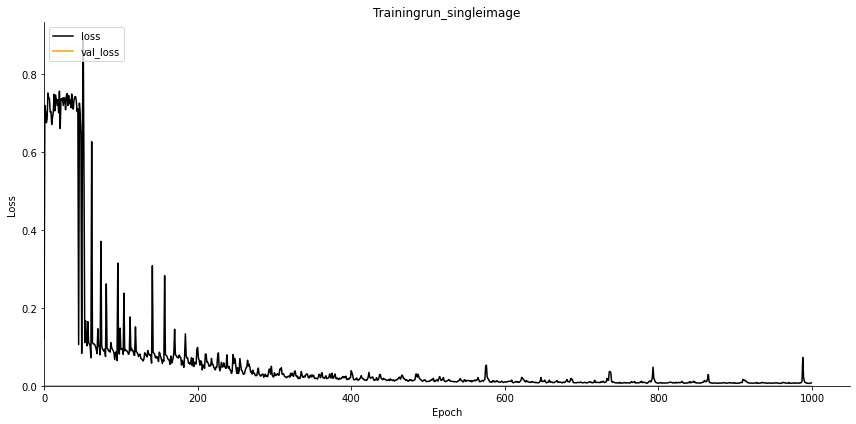

In [20]:
plot_TrainValLoss(model_info = singleimage_info, trainingrun = "singleimage", savefig = True, figpath = "Model_V1_Trainingrun_singleimage/LossGraphs/ModelLoss.png")

### 5.1.3 Test model on single image

In [22]:
# Test the model on predicting singleimage
output = model_V1.predict(singleimage_lab_predict_X)
output *= 128

output_array_lab = np.zeros((288, 320, 3))
output_array_lab[:, :, 0] = singleimage_lab_predict_X[0, :, :, 0]
output_array_lab[:, :, 1:] = output[0]
output_array_rgb = (lab2rgb(output_array_lab) * 255).astype(np.uint8)

imsave(f"Model_V1_Trainingrun_singleimage/Colourised/PokemonSilver_141_colourised.png", output_array_rgb)

RGB Image Summary
Object type: <class 'numpy.ndarray'>
Image dimensions: (288, 320, 3)
Number of channels: 3
R range: [0, 255]
G range: [0, 255]
B range: [0, 252]
RGB Image Summary
Object type: <class 'numpy.ndarray'>
Image dimensions: (288, 320, 3)
Number of channels: 3
R range: [0, 255]
G range: [0, 255]
B range: [0, 255]


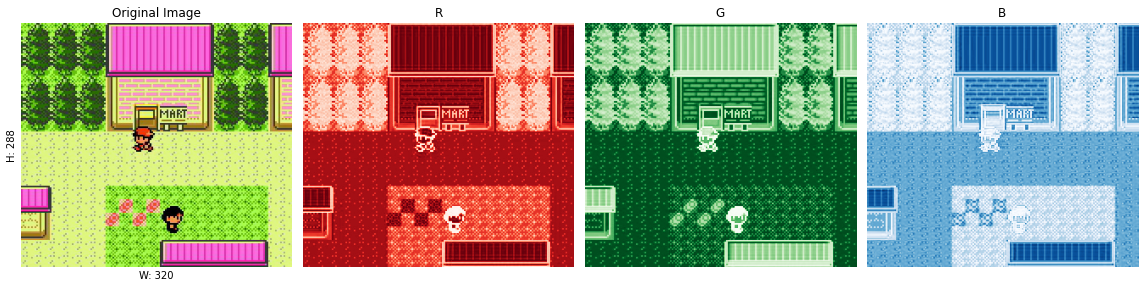

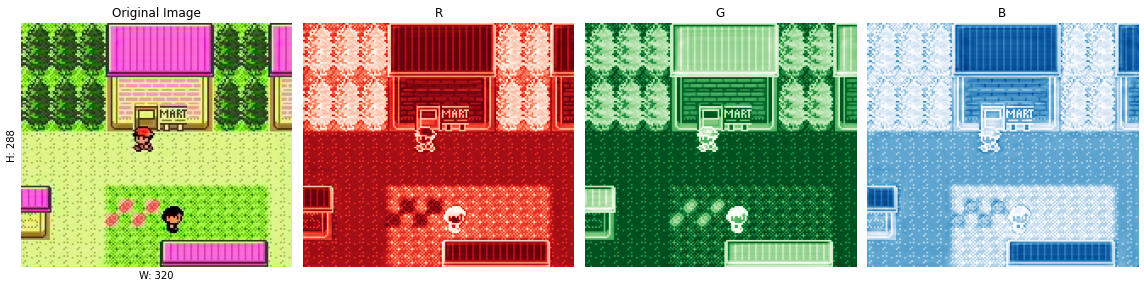

In [25]:
RGBimage_summary(singleimage_rgb)
RGBimage_summary(output_array_rgb)

---
## 6. Train the model

https://lambdalabs.com/blog/tensorflow-2-0-tutorial-03-saving-checkpoints/

Training logs:

**trainingrun_01**
 - len(Xtrain) = 6433
 - trainingrun = "01", 
 - Xtrain = Xtrain,
 - model = model_V1,
 - validation_split = 0.1,
 - batch_size = 50,
 - epochs = 100,
 - steps_per_epoch = len(Xtrain) // 50,
 - validation_steps = 1,
 - checkpoint_filepath = "Model_V0_Trainingrun_01/SavedCheckpoints/model.{epoch:02d}-{val_loss:.6f}.hdf5")
 
 
**training_run01 BEFORE**
 - Size of training set = approx. 2000
 - Epochs = 10
 - Batch size = 20
 - Steps per epoch = 50
 - Validation steps = 1

**training_run02 BEFORE**
 - Size of training set = approx. 6000
 - Epochs = 50
 - Batch size = 20
 - Steps per epoch = 289
 - Validation steps = 1